# V52 Wind Turbine Power Output forecast


This project deals with the power forecasting in a day-ahead basis using historical data of the V52 turbine located at DTU Riso Campus. The prediction shall be based only on power and the prediction shall be done 24 hours in advance. Later on, a market analysis will be done in order to find out the revenues that V52 can perform based on forecasted power and historical data of the Day-Ahead Nordpool electricity market. 

The code is structured in the following workflow, as detailed below: 
1.  Dataset import: V52 csv file and Nordpool DAM data xlsx file  
2.	Data preprocessing:  
2.1. Change format date  
2.2. Missing values (NaN) removal  
2.3. Interpolation to remove NaNs.   
2.4. Resizing into a 60 min time resolution  
2.5. Removing negatives values  
2.7. Calculation of the difference vector (non-stationarity)  
3.	LSTM Model definition  
3.1. Scaling  
3.2. Rolling window  
3.3. Building the delay matrix and the training matrix  
3.4. Building the LSTM Model   
3.5. Models creation (Model A, B, C, D)  
3.6. Models training (Model A, B, C, D)  
3.7. Training accuracy    
4.	Market Analysis: Estimate revenue & comparison with the current performance of V52  
4.1. Data Visualization  
4.2. Identification of the best day for the prediction   
5.  Power forecast  
5.1. Open loop prediction  
5.2. Upscaling  
5.3. Power signals forecast
6.  Market analysis: Comparison forecast and real data  
6.1. Revenues calculation  
6.2. Error Evaluation
7.  Conclusion  

## 1. Import Libraries and Datasets (V52 and Nordpool data)

In [1]:
# importing libraries for working directories
import os 

In [2]:
os.getcwd()

'C:\\Users\\Ingrid - CITCEA\\Documents\\Ironhack_Data_Science_Workshop\\Ironhack_Data_Science_Workshop2019'

In [36]:
# importing libraries for the project 
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import scipy as sp

# reading dataset 
dataset =  pd.read_csv('V52_ExtensiveData.csv', skiprows=12, header=0, delimiter='\t') 
dataset.head()


,Date,Wsp_44m,Wdir_41m,ActPow,RePow,ActPow_std,Wsp_44m_std,Wdir_41m_std,stability
0,201801010000,4.71803,200.743,64.6673,0.000860,33.4251,0.566131,6.45730,1.0
1,201801010010,5.44100,201.768,70.8152,-0.000657,26.3829,0.765691,6.66940,1.0
2,201801010020,5.32178,197.962,80.8037,-0.000617,30.2002,0.603442,6.99113,1.0
3,201801010030,5.95325,204.606,86.1123,-0.002370,43.1192,0.872915,5.47062,1.0
4,201801010040,6.17765,204.398,110.8570,0.001033,29.9507,0.550160,4.93713,1.0


## 2. Data Preprocessing

### 2.1 Change in the Date format 

In this dataset, we should set the index as the Date and time in the following format Y-m-d H:M:S



In [4]:
dataset.Date = pd.to_datetime(dataset.Date, format='%Y%m%d%H%M')

dataset.set_index('Date', inplace=True) # Inplace reassign dataset to indexed dataset
dataset.head()

,Wsp_44m,Wdir_41m,ActPow,RePow,ActPow_std,Wsp_44m_std,Wdir_41m_std,stability
Date,,,,,,,,
2018-01-01 00:00:00,4.71803,200.743,64.6673,0.000860,33.4251,0.566131,6.45730,1.0
2018-01-01 00:10:00,5.44100,201.768,70.8152,-0.000657,26.3829,0.765691,6.66940,1.0
2018-01-01 00:20:00,5.32178,197.962,80.8037,-0.000617,30.2002,0.603442,6.99113,1.0
2018-01-01 00:30:00,5.95325,204.606,86.1123,-0.002370,43.1192,0.872915,5.47062,1.0
2018-01-01 00:40:00,6.17765,204.398,110.8570,0.001033,29.9507,0.550160,4.93713,1.0


We can plot the dataset, to see how data looks like and how many missing values we have in this year of data

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001D6D7349FD0>,
      dtype=object)

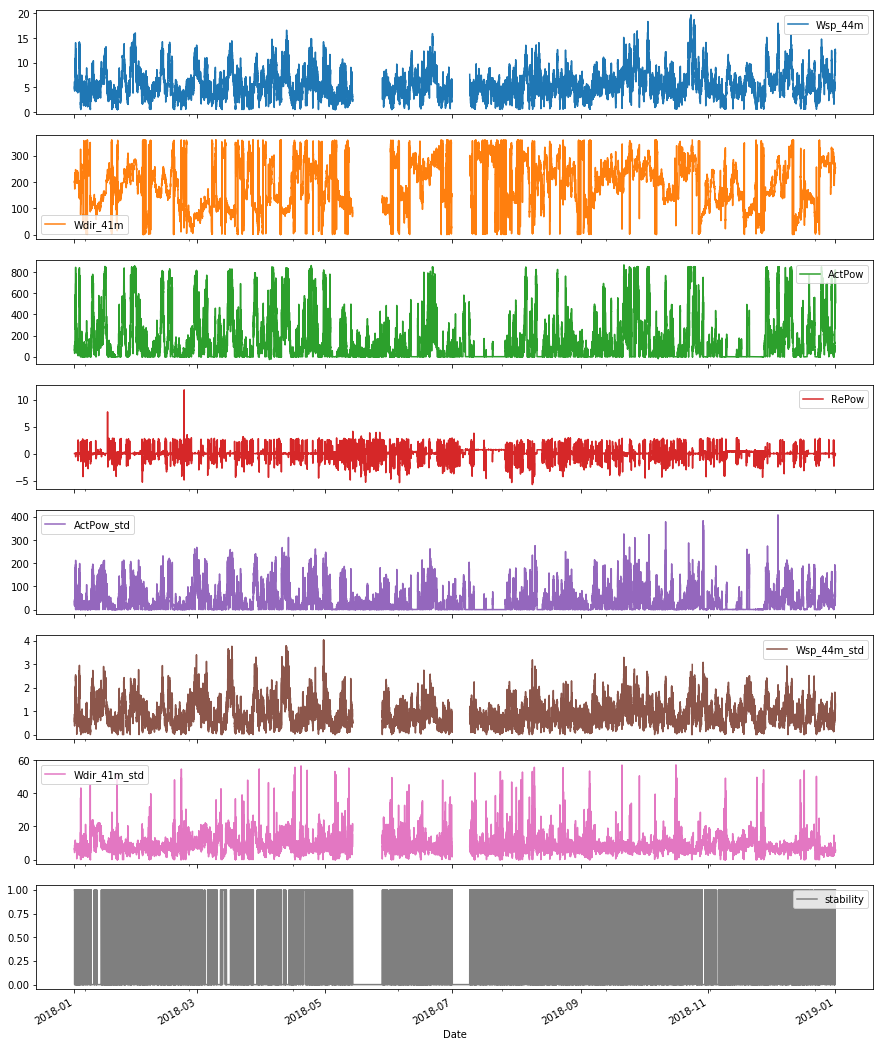

In [6]:
dataset.plot(subplots=True, figsize=(15,20))

Even if we have 8 features in this dataset, we will only work with Active Power (P) (MW), since it is the only variable we want to forecast. We remove all the columns that are not the ones required for the forecast model. In this case, we will only work with ActPow

In [40]:
datasetPow = dataset['ActPow']

###  2.2. MISSING VALUES REMOVAL

In [8]:
print('Null values: ', datasetPow.isnull().sum())

missing_time_stamps = pd.date_range(start='2018-01-01', end='2019-01-01', freq='10min').difference(datasetPow.index)
print(missing_time_stamps)
datasetPow.shape

Null values:  138
DatetimeIndex(['2018-01-01 13:30:00', '2018-01-01 15:50:00',
               '2018-01-02 20:20:00', '2018-01-03 00:20:00',
               '2018-01-03 18:50:00', '2018-01-04 22:00:00',
               '2018-01-06 18:20:00', '2018-01-06 19:50:00',
               '2018-01-06 20:00:00', '2018-01-07 11:40:00',
               ...
               '2018-11-21 17:20:00', '2018-11-23 17:10:00',
               '2018-11-24 18:30:00', '2018-11-25 17:00:00',
               '2018-11-25 17:10:00', '2018-11-26 20:30:00',
               '2018-12-01 17:10:00', '2018-12-03 23:10:00',
               '2018-12-05 17:00:00', '2018-12-05 19:30:00'],
              dtype='datetime64[ns]', length=321, freq=None)


(52241,)

There are two types of missing values we can have. first of all, Active Power values that are null, and then also missing indexes. 

There are 138 Active Power values that are null. 

There are 321 missing time stamps (indexes) 

Let's create a new dataframe with all the timestamps of year 2018, based on 10 minutes period. Then, we will make that this new DataFrame contains all the values from the previous DataFrame. 

In order to make this dataframe to have all the needed indexes for one year, we have dropped the last element of the row, to make it fit from 2018-01-01 00:00:00 until 2018-12-31 23:50:00.  


In [9]:
datevector = pd.date_range(start='2018-01-01 00:00:00', end='2019-01-01 00:00:00', freq='10min')
datasetActPow_full10 = pd.DataFrame(index= datevector)
datasetActPow_full10.index.name = 'Date'
datasetActPow_full10.head()
datasetActPow_full10['ActPow'] =  dataset['ActPow']

## remove the last row of the dataframe to have 52560 values
datasetActPow_full10.drop(datasetActPow_full10.tail(1).index, inplace = True)
datasetActPow_full10.tail()

,ActPow
Date,
2018-12-31 23:10:00,822.309
2018-12-31 23:20:00,759.568
2018-12-31 23:30:00,740.596
2018-12-31 23:40:00,632.185
2018-12-31 23:50:00,547.601


### 2.3.  Interpolation to remove NaNs
We have to deal with NaNs values in our 10 minutes range dataframe. Interpolation has been chosen as a method to interpolate at time period t between the previous 10' timeslot (t-1) and the following timeslot t+1 of historical data. 

ActPow    0
dtype: int64

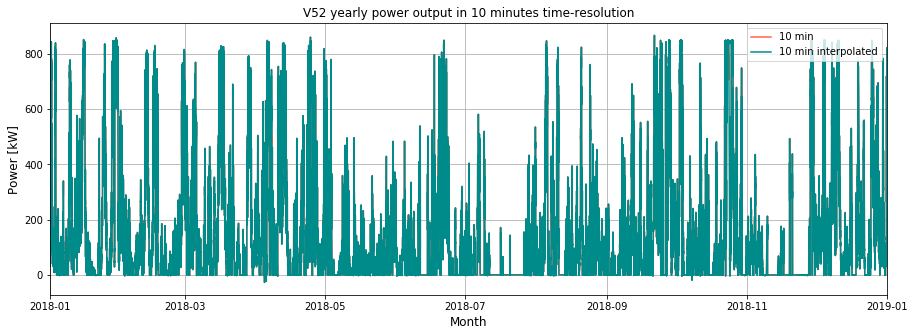

In [10]:
# interpolating the missing values in the dataset 
datasetActPow_full10_Interp=datasetActPow_full10.interpolate(method='linear')

# plotting the results 
plt.figure(figsize=(15,5))
plt.plot(datasetActPow_full10, color='tomato')
plt.plot(datasetActPow_full10_Interp, color='darkcyan')
plt.xlim('2018-01-01 00:00:00', '2019-01-01 00:00:00')
plt.grid(which='both')
plt.legend(['10 min', '10 min interpolated'], loc='upper right')
plt.title('V52 yearly power output in 10 minutes time-resolution')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Power [kW]', fontsize=12)

# checking how many missing values we still have 
datasetActPow_full10_Interp.isnull().sum()

### 2.4. Resizing into a 60 minute time resolution

Resample and mean methods are applied to resize this DataFrame into a new one of hourly resolution.

In the figure below both the results of the yearly power output on hourly resolution and 10 minutes resolution are provided. 


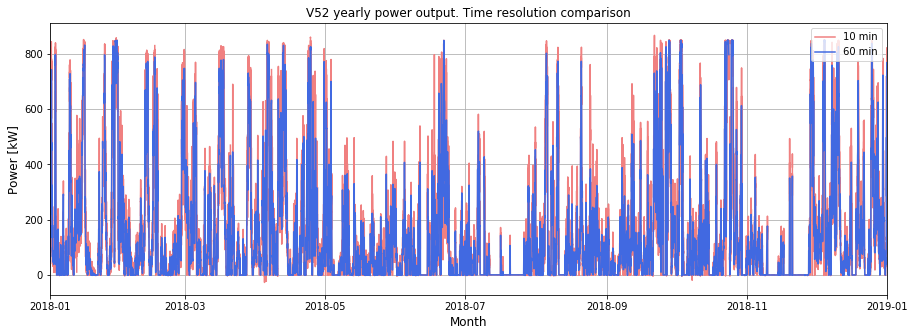

In [11]:
# resampling from 10' into 60'
datasetActPow_full60=datasetActPow_full10.resample('H').mean()

# plotting the results
plt.figure(figsize=(15,5))
plt.plot(datasetActPow_full10, color='lightcoral')
plt.plot(datasetActPow_full60, color='royalblue' )
plt.legend(['10 min', '60 min'], loc='upper right')
plt.title('V52 yearly power output. Time resolution comparison')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Power [kW]', fontsize=12)
plt.xlim('2018-01-01 00:00:00', '2019-01-01 00:00:00')
plt.grid(which='both')
plt.show()




### 2.5. Removal of negative values
As can be stated from the figure above, there are some negative values that have to be removed from the dataset, since they do not have any physical meaning. 


In [12]:
# checking negatives values 
datasetActPow_full60.min()

# removing negatives values
datasetActPow_full60_nonegative=datasetActPow_full60
datasetActPow_full60_nonegative[datasetActPow_full60_nonegative<0]=0
# checking again how many missing values we still have
datasetActPow_full60_nonegative.min()


ActPow   -3.976787
dtype: float64


ActPow    0.0
dtype: float64

The minimum value that the power output has it -3.9767 kW, and once it is removed from the DataFrame the minimum value is 0.0

### 2.7. Calculating the difference vector in V52 output power 

The data on which we are currently working are considered time series data. That means that these data also varies with time, meaning that also their properties change (mean, variance and covariace)

In order to reduce the non-stationarity that is on the V52 output power data, we convert the data into a differential dataset between t and t-1. In this case, negative values in the output power difference can be considered. 
This tranformation is done by means of pandas diff method. 

In [13]:
P_v52 = datasetActPow_full60_nonegative
P_v52_diff = P_v52.diff()
P_v52_diff[P_v52_diff.isnull()] = 0

P_v52_diff.head()

,ActPow
Date,
2018-01-01 00:00:00,0.000000
2018-01-01 01:00:00,-38.088700
2018-01-01 02:00:00,7.023100
2018-01-01 03:00:00,44.741233
2018-01-01 04:00:00,-35.613717


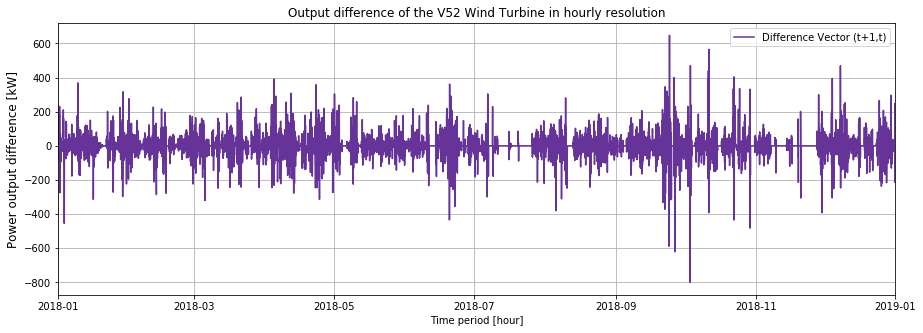

In [15]:
# plotting the difference power vector in hourly resolution 
plt.figure(figsize=(15,5))
plt.plot(P_v52_diff, color='rebeccapurple' , label= 'Difference Vector (t+1,t)')
axes = plt.gca()
axes.set_xlim(['2018-01-01','2019-01-01'])
plt.ylabel('Power output difference [kW]', fontsize = 12)
plt.xlabel('Time period [hour]')
plt.grid(which='major')
plt.title('Output difference of the V52 Wind Turbine in hourly resolution')
plt.legend()
plt.show()




## LSTM Model definition

Long short-term memory (LSTM) is an artificial recurrent neural network architecture used in the field of deep learning. Unlike standard feedforward neural networks, LSTM has feedback connections. A common LSTM unit is composed of a cell, an input gate, an output gat and a forget date. The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell. 

LSTM networks are well suited to classifying, processing and making predictions based on **time series** data, since there can be lags of unknown duration between important events in a time series.

More information about LSTM [**HERE**](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

### 3.1. Scaling
Since the power output of the wind turbine has a wide range, we prefer to scale it into -1 and 1. Also, bear in mind that we are working with the power output difference, and hence positive and negatives values can be found. 

Text(0.5, 1.0, 'Output power Difference vector scaling and transformation')

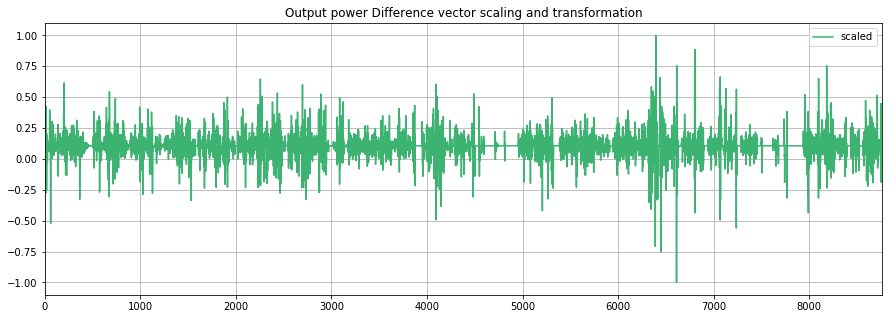

In [16]:
# importing the specific method for MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

# creating the minmax scaler object
scaler = MinMaxScaler(feature_range=(-1,1)) 
# fitting and transfroming the dataset 
P_v52_train = scaler.fit_transform(P_v52_diff)
P_v52_train.shape


# plotting the results 
plt.figure(figsize=(15,5))
plt.plot(P_v52_train, color = 'mediumseagreen')
plt.legend(['scaled'], loc='upper right')
plt.xlim(0,8761)
plt.grid()
plt.title('Output power Difference vector scaling and transformation', fontsize = 12)



### 3.2. Rolling Window: Building the delay matrix and the training matrix

In [17]:
# Creating new dataframe with scaled signal
datevector2 = pd.date_range(start='2018-01-01 00:00:00', end='2018-12-31 23:50:00', freq='H')
P_v52_df = pd.DataFrame(index= datevector2)
P_v52_df.index.name = 'Date'
P_v52_df['ActPow'] =  P_v52_train
P_v52_df.head()

,ActPow
Date,
2018-01-01 00:00:00,0.105865
2018-01-01 01:00:00,0.053233
2018-01-01 02:00:00,0.115569
2018-01-01 03:00:00,0.167689
2018-01-01 04:00:00,0.056653


In the following lines, we prepared different models in which we investigate the hyperparameters of the amount of past states to consider for the prediction of the following state of the neural network.

In this investigation, all the other hyperparameters (e.g. epochs, number of hidden layers and neurons per layer, etc) are kept constant.

MODEL A = 1 day past

MODEL B = 3 days past

MODEL C = 7 days past

MODEL D = 14 days past


In [18]:
import scipy as sp

days_past_A=1
n_window_A=days_past_A*24
toepl_1row_A=np.zeros(n_window_A+1)
toepl_1row_A[0]=P_v52_df.values[0]
idx_A=sp.linalg.toeplitz(P_v52_df,toepl_1row_A)
P_v52_train_delays_A=idx_A

days_past_B=3
n_window_B=days_past_B*24
toepl_1row_B=np.zeros(n_window_B+1)
toepl_1row_B[0]=P_v52_df.values[0]
idx_B=sp.linalg.toeplitz(P_v52_df,toepl_1row_B)
P_v52_train_delays_B=idx_B

days_past_C=7
n_window_C=days_past_C*24
toepl_1row_C=np.zeros(n_window_C+1)
toepl_1row_C[0]=P_v52_df.values[0]
idx_C=sp.linalg.toeplitz(P_v52_df,toepl_1row_C)
P_v52_train_delays_C=idx_C

days_past_D=14
n_window_D=days_past_D*24
toepl_1row_D=np.zeros(n_window_D+1)
toepl_1row_D[0]=P_v52_df.values[0]
idx_D=sp.linalg.toeplitz(P_v52_df,toepl_1row_D)
P_v52_train_delays_D=idx_D



In [19]:
# deep learning and neural networks libraries 
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.layers import LSTM

Using TensorFlow backend.


### 3.4. Building the LSTM Model 

In [20]:
# for multiple model creation - clear  the previous DAG
K.clear_session() 

### Input reshape for LSTM problem  [samples, timesteps, features]
train_X_A = P_v52_train_delays_A[:,1:]
train_Y_A = P_v52_train_delays_A[:,0]

train_X_B = P_v52_train_delays_B[:,1:]
train_Y_B = P_v52_train_delays_B[:,0]

train_X_C = P_v52_train_delays_C[:,1:]
train_Y_C = P_v52_train_delays_C[:,0]

train_X_D = P_v52_train_delays_D[:,1:]
train_Y_D = P_v52_train_delays_D[:,0]


# Printing shape of training datasets. Last dimension is the number of past values considered. 
# They are consistent

# train_X_exp=np.expand_dims(train_X,axis=0)
print(train_X_A.shape)
print(train_X_B.shape)
print(train_X_C.shape)
print(train_X_D.shape)

# print(train_X_exp.shape)

(8760, 24)
(8760, 72)
(8760, 168)
(8760, 336)


In [21]:
# create model
n_samples_A=train_X_A.shape[0]
n_in_A=train_X_A.shape[1]

n_samples_B=train_X_B.shape[0]
n_in_B=train_X_B.shape[1]

n_samples_C=train_X_C.shape[0]
n_in_C=train_X_C.shape[1]

n_samples_D=train_X_D.shape[0]
n_in_D=train_X_D.shape[1]

n_features=1

train_X_input_A = train_X_A.reshape(train_X_A.shape[0], 1, train_X_A.shape[1])
train_X_input_B = train_X_B.reshape(train_X_B.shape[0], 1, train_X_B.shape[1])
train_X_input_C = train_X_C.reshape(train_X_C.shape[0], 1, train_X_C.shape[1])
train_X_input_D = train_X_D.reshape(train_X_D.shape[0], 1, train_X_D.shape[1])

### 3.5. Models creation

In the following section, four models are created. The hyperparameters that have been chosen are the following ones: 

- 2 Hidden layers (120 and 80 neurons) 
- Activation function: Relu (1st hidden layer)
- Activation function: Linear (2nd hidden layer)
- 250 epochs training
- Loss function: Mean Squared error


In [22]:
model_A = Sequential()
# model.add(LSTM(120, input_shape=(n_samples,n_in,n_features), 
# model.add(LSTM(120, input_shape=(train_X.shape[0],train_X.shape[1],1), 
model_A.add(LSTM(120, input_shape=(train_X_input_A.shape[1],train_X_input_A.shape[2]), 

                kernel_initializer='random_uniform', activation='relu',
                bias_initializer='zeros',
                return_sequences=True)) # important to add it to ensure the following LSTM layers will have the same input shape
# then we add the activation
# model.add(Activation('tanh'))
model_A.add(LSTM(80, activation ='relu'))
# we add Drop-out with a ratio that will put up to 20% of the inputs (to the layer) to zero, feel free to tune it
# model.add(Dropout(0.8))
model_A.add(Dense(1, activation='linear'))

# compile the model
model_A.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])


model_B = Sequential()
model_B.add(LSTM(120, input_shape=(train_X_input_B.shape[1],train_X_input_B.shape[2]), 

                kernel_initializer='random_uniform', activation='relu',
                bias_initializer='zeros',
                return_sequences=True))
model_B.add(LSTM(80, activation ='relu'))
model_B.add(Dense(1, activation='linear'))
model_B.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

model_C = Sequential()
model_C.add(LSTM(120, input_shape=(train_X_input_C.shape[1],train_X_input_C.shape[2]), 

                kernel_initializer='random_uniform', activation='relu',
                bias_initializer='zeros',
                return_sequences=True))
model_C.add(LSTM(80, activation ='relu'))
model_C.add(Dense(1, activation='linear'))
model_C.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

model_D = Sequential()
model_D.add(LSTM(120, input_shape=(train_X_input_D.shape[1],train_X_input_D.shape[2]), 

                kernel_initializer='random_uniform', activation='relu',
                bias_initializer='zeros',
                return_sequences=True))
model_D.add(LSTM(80, activation ='relu'))
model_D.add(Dense(1, activation='linear'))
model_D.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])



### 3.6. Models training 

The estimated training time is 2 seconds/epoch. However, it depends on the computer training the model. 
In this case, the estimated time is: 

\begin{equation*}
    2 · 250 · 4 \approx 2000  s 
\end{equation*}
Furthermore, the number of past values does not affect the training time so much in the model defined in this capstone project. 


In [23]:
# Training model A 
history_A = model_A.fit(train_X_input_A, train_Y_A, epochs=250, verbose=2)

Epoch 1/250
 - 5s - loss: 0.0080 - mean_squared_error: 0.0080
Epoch 2/250
 - 2s - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 3/250
 - 2s - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 4/250
 - 2s - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 5/250
 - 2s - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 6/250
 - 2s - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 7/250
 - 5s - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 8/250
 - 4s - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 9/250
 - 2s - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 10/250
 - 2s - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 11/250
 - 3s - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 12/250
 - 2s - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 13/250
 - 3s - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 14/250
 - 2s - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 15/250
 - 2s - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 16/250
 - 2s - loss: 0.0062 - mean_squared_error: 0.0062
E

Epoch 131/250
 - 2s - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 132/250
 - 2s - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 133/250
 - 2s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 134/250
 - 2s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 135/250
 - 2s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 136/250
 - 2s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 137/250
 - 2s - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 138/250
 - 2s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 139/250
 - 2s - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 140/250
 - 2s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 141/250
 - 2s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 142/250
 - 2s - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 143/250
 - 2s - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 144/250
 - 2s - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 145/250
 - 2s - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 146/250
 - 2s - loss: 0.0022 - mea

In [24]:
# Training model B 
history_B = model_B.fit(train_X_input_B, train_Y_B, epochs=250, verbose=2)

Epoch 1/250
 - 5s - loss: 0.0078 - mean_squared_error: 0.0078
Epoch 2/250
 - 2s - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 3/250
 - 2s - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 4/250
 - 2s - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 5/250
 - 2s - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 6/250
 - 2s - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 7/250
 - 2s - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 8/250
 - 2s - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 9/250
 - 2s - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 10/250
 - 2s - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 11/250
 - 2s - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 12/250
 - 2s - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 13/250
 - 2s - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 14/250
 - 2s - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 15/250
 - 2s - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 16/250
 - 2s - loss: 0.0046 - mean_squared_error: 0.0046
E

 - 2s - loss: 8.3246e-04 - mean_squared_error: 8.3246e-04
Epoch 129/250
 - 2s - loss: 8.1917e-04 - mean_squared_error: 8.1917e-04
Epoch 130/250
 - 2s - loss: 8.5179e-04 - mean_squared_error: 8.5179e-04
Epoch 131/250
 - 2s - loss: 8.7691e-04 - mean_squared_error: 8.7691e-04
Epoch 132/250
 - 2s - loss: 8.6153e-04 - mean_squared_error: 8.6153e-04
Epoch 133/250
 - 2s - loss: 8.3253e-04 - mean_squared_error: 8.3253e-04
Epoch 134/250
 - 2s - loss: 8.0081e-04 - mean_squared_error: 8.0081e-04
Epoch 135/250
 - 2s - loss: 7.7800e-04 - mean_squared_error: 7.7800e-04
Epoch 136/250
 - 2s - loss: 8.2002e-04 - mean_squared_error: 8.2002e-04
Epoch 137/250
 - 2s - loss: 7.8531e-04 - mean_squared_error: 7.8531e-04
Epoch 138/250
 - 2s - loss: 8.1055e-04 - mean_squared_error: 8.1055e-04
Epoch 139/250
 - 2s - loss: 7.7752e-04 - mean_squared_error: 7.7752e-04
Epoch 140/250
 - 2s - loss: 7.3810e-04 - mean_squared_error: 7.3810e-04
Epoch 141/250
 - 2s - loss: 7.9616e-04 - mean_squared_error: 7.9616e-04
Epoch 

Epoch 242/250
 - 6s - loss: 4.0186e-04 - mean_squared_error: 4.0186e-04
Epoch 243/250
 - 4s - loss: 4.2549e-04 - mean_squared_error: 4.2549e-04
Epoch 244/250
 - 4s - loss: 4.0939e-04 - mean_squared_error: 4.0939e-04
Epoch 245/250
 - 3s - loss: 4.1144e-04 - mean_squared_error: 4.1144e-04
Epoch 246/250
 - 2s - loss: 4.4036e-04 - mean_squared_error: 4.4036e-04
Epoch 247/250
 - 2s - loss: 4.3750e-04 - mean_squared_error: 4.3750e-04
Epoch 248/250
 - 3s - loss: 4.3724e-04 - mean_squared_error: 4.3724e-04
Epoch 249/250
 - 2s - loss: 4.4289e-04 - mean_squared_error: 4.4289e-04
Epoch 250/250
 - 2s - loss: 4.0586e-04 - mean_squared_error: 4.0586e-04


In [25]:
# Training model C 
history_C = model_C.fit(train_X_input_C, train_Y_C, epochs=250, verbose=2)

Epoch 1/250
 - 5s - loss: 0.0078 - mean_squared_error: 0.0078
Epoch 2/250
 - 3s - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 3/250
 - 2s - loss: 0.0074 - mean_squared_error: 0.0074
Epoch 4/250
 - 2s - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 5/250
 - 2s - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 6/250
 - 2s - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 7/250
 - 2s - loss: 0.0070 - mean_squared_error: 0.0070
Epoch 8/250
 - 2s - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 9/250
 - 2s - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 10/250
 - 2s - loss: 0.0060 - mean_squared_error: 0.0060
Epoch 11/250
 - 2s - loss: 0.0057 - mean_squared_error: 0.0057
Epoch 12/250
 - 2s - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 13/250
 - 2s - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 14/250
 - 2s - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 15/250
 - 2s - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 16/250
 - 2s - loss: 0.0044 - mean_squared_error: 0.0044
E

Epoch 123/250
 - 2s - loss: 3.2859e-04 - mean_squared_error: 3.2859e-04
Epoch 124/250
 - 2s - loss: 3.3922e-04 - mean_squared_error: 3.3922e-04
Epoch 125/250
 - 2s - loss: 3.1902e-04 - mean_squared_error: 3.1902e-04
Epoch 126/250
 - 2s - loss: 3.2357e-04 - mean_squared_error: 3.2357e-04
Epoch 127/250
 - 2s - loss: 3.4435e-04 - mean_squared_error: 3.4435e-04
Epoch 128/250
 - 3s - loss: 3.6588e-04 - mean_squared_error: 3.6588e-04
Epoch 129/250
 - 2s - loss: 3.5226e-04 - mean_squared_error: 3.5226e-04
Epoch 130/250
 - 2s - loss: 2.8991e-04 - mean_squared_error: 2.8991e-04
Epoch 131/250
 - 2s - loss: 2.9649e-04 - mean_squared_error: 2.9649e-04
Epoch 132/250
 - 2s - loss: 2.8719e-04 - mean_squared_error: 2.8719e-04
Epoch 133/250
 - 2s - loss: 2.9428e-04 - mean_squared_error: 2.9428e-04
Epoch 134/250
 - 2s - loss: 2.7822e-04 - mean_squared_error: 2.7822e-04
Epoch 135/250
 - 2s - loss: 2.8631e-04 - mean_squared_error: 2.8631e-04
Epoch 136/250
 - 2s - loss: 3.0367e-04 - mean_squared_error: 3.0

Epoch 237/250
 - 3s - loss: 1.7128e-04 - mean_squared_error: 1.7128e-04
Epoch 238/250
 - 2s - loss: 1.5875e-04 - mean_squared_error: 1.5875e-04
Epoch 239/250
 - 2s - loss: 1.4906e-04 - mean_squared_error: 1.4906e-04
Epoch 240/250
 - 2s - loss: 1.3982e-04 - mean_squared_error: 1.3982e-04
Epoch 241/250
 - 3s - loss: 1.4388e-04 - mean_squared_error: 1.4388e-04
Epoch 242/250
 - 4s - loss: 1.4095e-04 - mean_squared_error: 1.4095e-04
Epoch 243/250
 - 3s - loss: 1.6335e-04 - mean_squared_error: 1.6335e-04
Epoch 244/250
 - 3s - loss: 1.3996e-04 - mean_squared_error: 1.3996e-04
Epoch 245/250
 - 2s - loss: 1.3337e-04 - mean_squared_error: 1.3337e-04
Epoch 246/250
 - 2s - loss: 1.2915e-04 - mean_squared_error: 1.2915e-04
Epoch 247/250
 - 3s - loss: 1.4066e-04 - mean_squared_error: 1.4066e-04
Epoch 248/250
 - 4s - loss: 1.3671e-04 - mean_squared_error: 1.3671e-04
Epoch 249/250
 - 2s - loss: 1.4203e-04 - mean_squared_error: 1.4203e-04
Epoch 250/250
 - 2s - loss: 1.4946e-04 - mean_squared_error: 1.4

In [26]:
# Training model D 
history_D = model_D.fit(train_X_input_D, train_Y_D, epochs=250, verbose=2)

Epoch 1/250
 - 7s - loss: 0.0079 - mean_squared_error: 0.0079
Epoch 2/250
 - 4s - loss: 0.0075 - mean_squared_error: 0.0075
Epoch 3/250
 - 3s - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 4/250
 - 3s - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 5/250
 - 4s - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 6/250
 - 9s - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 7/250
 - 4s - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 8/250
 - 3s - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 9/250
 - 3s - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 10/250
 - 3s - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 11/250
 - 5s - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 12/250
 - 3s - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 13/250
 - 3s - loss: 0.0053 - mean_squared_error: 0.0053
Epoch 14/250
 - 6s - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 15/250
 - 3s - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 16/250
 - 3s - loss: 0.0047 - mean_squared_error: 0.0047
E

Epoch 123/250
 - 3s - loss: 2.4598e-04 - mean_squared_error: 2.4598e-04
Epoch 124/250
 - 3s - loss: 2.3465e-04 - mean_squared_error: 2.3465e-04
Epoch 125/250
 - 3s - loss: 2.3963e-04 - mean_squared_error: 2.3963e-04
Epoch 126/250
 - 3s - loss: 2.4287e-04 - mean_squared_error: 2.4287e-04
Epoch 127/250
 - 3s - loss: 2.4835e-04 - mean_squared_error: 2.4835e-04
Epoch 128/250
 - 6s - loss: 2.5877e-04 - mean_squared_error: 2.5877e-04
Epoch 129/250
 - 3s - loss: 2.1515e-04 - mean_squared_error: 2.1515e-04
Epoch 130/250
 - 3s - loss: 2.5368e-04 - mean_squared_error: 2.5368e-04
Epoch 131/250
 - 3s - loss: 2.2132e-04 - mean_squared_error: 2.2132e-04
Epoch 132/250
 - 3s - loss: 2.3893e-04 - mean_squared_error: 2.3893e-04
Epoch 133/250
 - 4s - loss: 2.5573e-04 - mean_squared_error: 2.5573e-04
Epoch 134/250
 - 4s - loss: 2.0726e-04 - mean_squared_error: 2.0726e-04
Epoch 135/250
 - 9s - loss: 1.9208e-04 - mean_squared_error: 1.9208e-04
Epoch 136/250
 - 3s - loss: 1.9047e-04 - mean_squared_error: 1.9

Epoch 237/250
 - 3s - loss: 9.1077e-05 - mean_squared_error: 9.1077e-05
Epoch 238/250
 - 3s - loss: 9.3485e-05 - mean_squared_error: 9.3485e-05
Epoch 239/250
 - 3s - loss: 1.2773e-04 - mean_squared_error: 1.2773e-04
Epoch 240/250
 - 3s - loss: 1.1824e-04 - mean_squared_error: 1.1824e-04
Epoch 241/250
 - 3s - loss: 1.1235e-04 - mean_squared_error: 1.1235e-04
Epoch 242/250
 - 3s - loss: 9.8400e-05 - mean_squared_error: 9.8400e-05
Epoch 243/250
 - 3s - loss: 7.8713e-05 - mean_squared_error: 7.8713e-05
Epoch 244/250
 - 2s - loss: 7.7613e-05 - mean_squared_error: 7.7613e-05
Epoch 245/250
 - 3s - loss: 7.8550e-05 - mean_squared_error: 7.8550e-05
Epoch 246/250
 - 3s - loss: 9.5595e-05 - mean_squared_error: 9.5595e-05
Epoch 247/250
 - 4s - loss: 1.1789e-04 - mean_squared_error: 1.1789e-04
Epoch 248/250
 - 3s - loss: 1.1094e-04 - mean_squared_error: 1.1094e-04
Epoch 249/250
 - 3s - loss: 9.3093e-05 - mean_squared_error: 9.3093e-05
Epoch 250/250
 - 5s - loss: 8.2256e-05 - mean_squared_error: 8.2

### 3.7. Training accuracy 

Below we can see that the loss function is lower for models that account for more past output states (i.e. Models C and D)

They reach a better accuracy and also faster (i.e. after 150 epochs the models do not change much in accuracy)


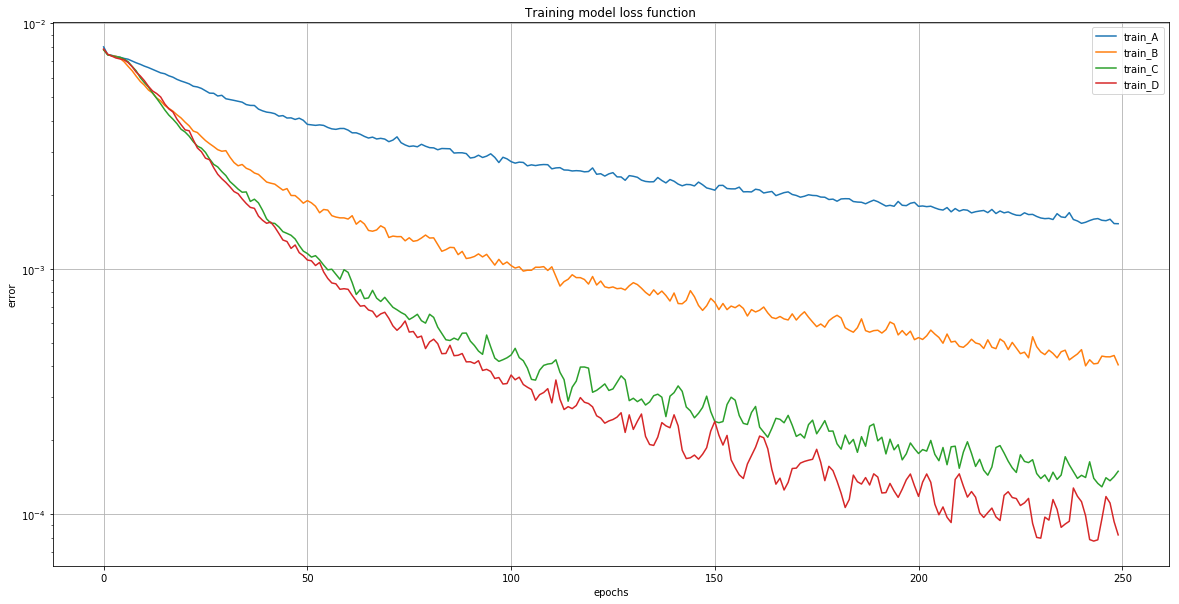

In [27]:
#plotting loss function of the model 
plt.figure(figsize=(20,10))
plt.plot(history_A.history['loss'], label='train_A')
plt.plot(history_B.history['loss'], label='train_B')
plt.plot(history_C.history['loss'], label='train_C')
plt.plot(history_D.history['loss'], label='train_D')
plt.grid(which='major')
plt.title('Training model loss function')
plt.xlabel('epochs')
plt.ylabel('error')
plt.yscale('log')
plt.legend()
plt.show()



As we can see from the plot above, we have to decide the tradeoff between accuracy and stability. For example, model D achieves lower values of absolute error. However, this model has serious stability problems. 

## 4 Market Analysis based on Nordpool DAM

In this section, the power forecast is being assessed by means of its economic value, considering the available market data from 2018 of the Nordpool DAM. The zone where the V52 turbine is located and, whereas, can bid to the DAM is DK2 zone (Riso DTU Campus). In the following figure, the Nordpool market zones are shown, covering the following countries: Denmark (divided into Eastern Denmark and Western Denmark), Finland, Estona, Lithuania, Latvia, Norway (five bidding zones) and Sweden (divided into four bidding zones). 

![Source: Nordpool Electricity Market](https://www.nordpoolgroup.com/globalassets/images/graphics/bidding_areas-002.png?width=200&quality=90)

### 4.1. Data visualization
In the figure below, the 2018 hourly prices of DK2 bidding area can be observed. Furthermore, the maximum DAM price is obtained. 

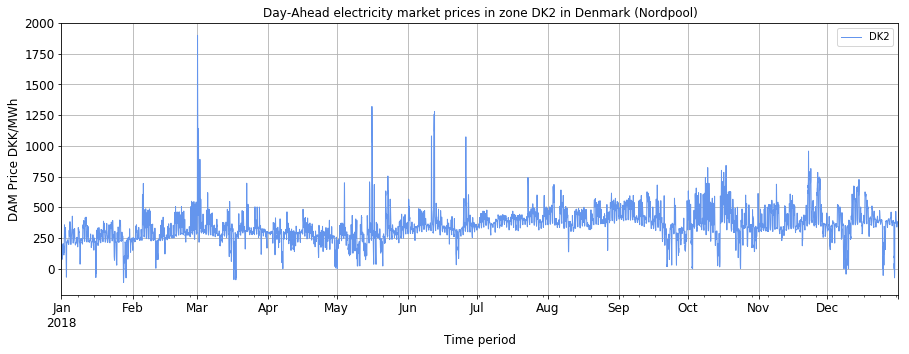

The maximum DAM price was: [1898.9] DKK/MWh on ['2018-03-01T08:00:00.000000000']


In [28]:
file = 'elspot-prices_2018_hourly_dkk_v2.xlsx' 
 
#Parsing input file 
dataset_price = pd.read_excel(file, skiprows=2, header = 0, index_col = 0, decimal=',', thousands=None)
datevector = pd.date_range(start = '2018-01-01', end='2019-01-01', freq='1H') #we create an index vector of all the time
dataset_price.index = datevector
dataset_price_DK2 = dataset_price.loc[:,['DK2']]

# we just need the data from DK2
ax = dataset_price_DK2.plot(figsize = (15,5), linewidth = 1, fontsize = 12, label ='DK2 price', color='cornflowerblue')
plt.title('Day-Ahead electricity market prices in zone DK2 in Denmark (Nordpool)')
plt.ylabel('DAM Price DKK/MWh', fontsize=12)
plt.xlabel('Time period', fontsize=12)
plt.grid(which='major')
plt.xlim('2018-01-01 00:00:00', '2018-12-31 23:00:00')
plt.legend()
plt.show()

# find the maximum price of 2018
max_DK2_DAM_price = dataset_price_DK2.max()
max_DK2_DAM_day = dataset_price_DK2.idxmax()
print('The maximum DAM price was:', max_DK2_DAM_price.values, 'DKK/MWh on', max_DK2_DAM_day.values)

### 4.2 Indentification of the best day for the prediction

In order to find the best day to test our prediction, the revenues obtained on each day considering the hourly electricity price and the hourly power calculated precendently, has been considered. 

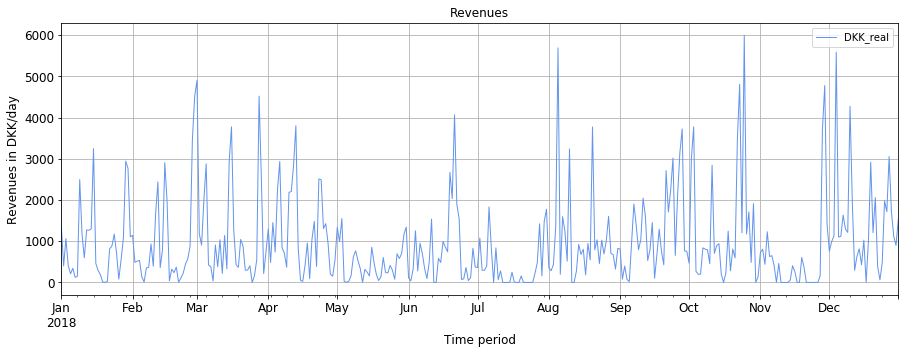

The maximum revenue per day in the year was: [5998.01857952] DKK on  ['2018-10-25T00:00:00.000000000']


In [29]:
dataset_price_DK2 = dataset_price_DK2.rename_axis("Date")

#Create dataframe with hourly electricity price and production
MergedData = pd.merge(dataset_price_DK2,P_v52,\ 
                      how = 'inner', on = 'Date')

#Create a revenue dataframe in which the hourly reveues are reported
Revenues = MergedData.DK2 * MergedData.ActPow/1000
Revenues = Revenues.to_frame(name = 'DKK_real')
Revenues.index = pd.to_datetime(Revenues.index)

#Resample the revenues dataframe to have the revenues per day and identify the best day to test the prediction
Revenues_per_day = Revenues.resample('1D').sum()

#Plot the revenues per day
ax = Revenues_per_day.plot(figsize = (15,5), linewidth = 1, fontsize = 12, label ='DK2 price', color='cornflowerblue')

plt.title('Revenues')
plt.ylabel('Revenues in DKK/day', fontsize=12)
plt.xlabel('Time period', fontsize=12)
plt.grid(which='major')
plt.xlim('2018-01-01', '2018-12-31')
plt.legend()
plt.show()

#Determine the maximum revenues and the corresponding day: 
Max_revenue_per_day = Revenues_per_day.max().values
Day_max_revenue = Revenues_per_day.idxmax().values

print('The maximum revenue per day in the year was:', Max_revenue_per_day, 'DKK on ', Day_max_revenue)

Based on the analysis, the day allowing the higher revenues is the 25th of October 2018. For this reason the comparison between prediction and real data will be made on this date.

In [30]:
#Start_ind corresponds to the row associated to the first hour of the selected day
start_ind=P_v52.index.get_loc('2018-10-25 00:00')
end_ind=P_v52.index.get_loc('2018-10-25 23:00')
print(start_ind)
print(end_ind)

7128
7151


## 5. Power forecast 

In this section the V52 power output is forecasted. However, it has to be remarked that this prediction is done in the so called open-loop configuration. That means that the real power data (i.e. those used during the training process) are assumed as available also for the prediciton. Hence, our networks use REAL past power output values to estimate the next input.

_- I.e. To estimate Yt we use the past outputs states {Y(t-1)...Y(t-n)} taken from the training dataset, and NOT the {Y(t-1)...Y(t-n)} predicted from the neural networks_

### 5.1 Open loop prediction

In [31]:
## OPEN LOOP PREDICTION
# OPEN LOOP: We assume that the REAL power data (i.e. those used during the training process) are available also for the prediction
# THis means that our networks use REAL pas outputs to estimate the next input. I.e. To estimate Yt we use the past outputs states
# {Y(t-1)...Y(t-n)} taken from the training dataset, and NOT the {Y(t-1)...Y(t-n)} predicted from the neural networks

test_X_A=train_X_input_A[start_ind+1:end_ind+1,:,:]
test_X_B=train_X_input_B[start_ind+1:end_ind+1,:,:]
test_X_C=train_X_input_C[start_ind+1:end_ind+1,:,:]
test_X_D=train_X_input_D[start_ind+1:end_ind+1,:,:]

Y_predict_A=model_A.predict(test_X_A)
Y_predict_B=model_B.predict(test_X_B)
Y_predict_C=model_C.predict(test_X_C)
Y_predict_D=model_D.predict(test_X_D)

### 5.2. Upscaling

In [32]:
Y_predict_upscaled_A=scaler.inverse_transform(Y_predict_A)
Y_predict_upscaled_B=scaler.inverse_transform(Y_predict_B)
Y_predict_upscaled_C=scaler.inverse_transform(Y_predict_C)
Y_predict_upscaled_D=scaler.inverse_transform(Y_predict_D)

### 5.3. Power signals forecast 

As can be seen in the figure below, clearly model D outperforms other models. However, once again it has to be remarked that it is an **open-loop** prediction. 

In an eventual closed-loop prediction, the performance of all the models is expected to decrease.


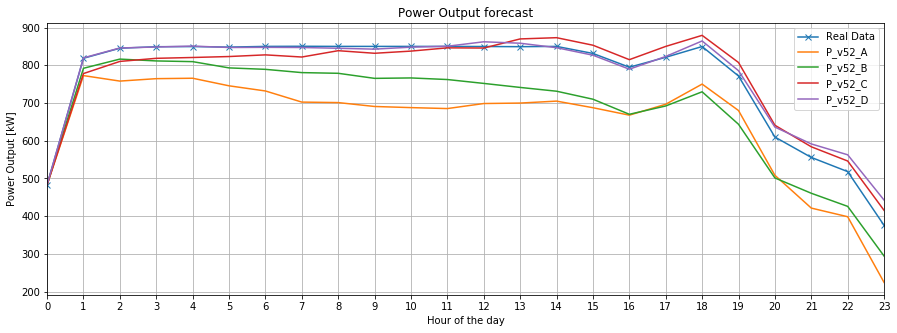

In [33]:
P_v52_predicted_A=[]
P_v52_predicted_B=[]
P_v52_predicted_C=[]
P_v52_predicted_D=[]


P_v52_predicted_A.append(P_v52.values[start_ind])
P_v52_predicted_B.append(P_v52.values[start_ind])
P_v52_predicted_C.append(P_v52.values[start_ind])
P_v52_predicted_D.append(P_v52.values[start_ind])


for i in range(1,len(Y_predict_upscaled_A)+1) :
    P_v52_predicted_A.append(P_v52_predicted_A[i-1] + Y_predict_upscaled_A[i-1])
    P_v52_predicted_B.append(P_v52_predicted_B[i-1] + Y_predict_upscaled_B[i-1])
    P_v52_predicted_C.append(P_v52_predicted_C[i-1] + Y_predict_upscaled_C[i-1])
    P_v52_predicted_D.append(P_v52_predicted_D[i-1] + Y_predict_upscaled_D[i-1])

# plotting the power output forecast for one day 
plt.figure(figsize=(15,5))
plt.plot(P_v52.values[start_ind:end_ind+1], label='Real Data', marker='x')
plt.plot(P_v52_predicted_A, label='P_v52_A')
plt.plot(P_v52_predicted_B, label='P_v52_B')
plt.plot(P_v52_predicted_C, label='P_v52_C')
plt.plot(P_v52_predicted_D, label='P_v52_D')
plt.xlim((0,23))
plt.xticks(np.arange(24))
plt.xlabel('Hour of the day')
plt.ylabel('Power Output [kW]')
plt.grid()
plt.title('Power Output forecast')
plt.legend()
plt.show()

## 6. Market analysis: Comparison forecast and real data. 

### 6.1 Revenues calculation
To test the forecast quality, the predicted revenues and the real ones are compared for the hours of the selected day.

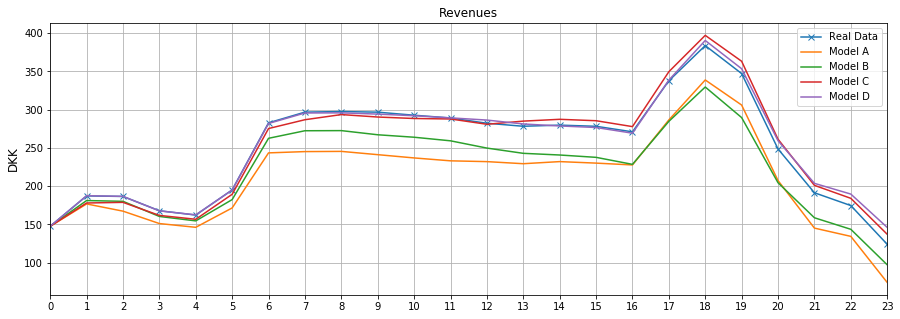

In [34]:
#Real revenues
Revenues_best_day_REAL = Revenues[(Revenues.index > '2018-10-24 23:59') & (Revenues.index < '2018-10-26 00:00')]

#Electricity cost for the selected day
dataset_price_best_day = dataset_price_DK2[(dataset_price_DK2.index > '2018-10-24 23:59')
                                           & (dataset_price_DK2.index < '2018-10-26 00:00')]
#time vector for the predicted values
time = pd.date_range(start = '2018-10-25 00:00', end='2018-10-25 23:00', freq='1H')

#Power prediction model A
power_prediction_A = pd.DataFrame(P_v52_predicted_A)
#Revenues prediction model A
Revenues_A = power_prediction_A.values*dataset_price_best_day.values/1000
Revenues_best_day_prediction_A = pd.DataFrame(Revenues_A, index = [time], columns = ['DKK_model_A'])

#Power prediction model B
power_prediction_B = pd.DataFrame(P_v52_predicted_B)
#Revenues prediction model B
Revenues_B = power_prediction_B.values*dataset_price_best_day.values/1000
Revenues_best_day_prediction_B = pd.DataFrame(Revenues_B, index = [time], columns = ['DKK_model_B'])


#Power prediction model C
power_prediction_C = pd.DataFrame(P_v52_predicted_C)
#Revenues prediction model C
Revenues_C = power_prediction_C.values*dataset_price_best_day.values/1000
Revenues_best_day_prediction_C = pd.DataFrame(Revenues_C, index = [time], columns = ['DKK_model_C'])

#Power prediction model D
power_prediction_D = pd.DataFrame(P_v52_predicted_D)
#Revenues prediction model D
Revenues_D = power_prediction_D.values*dataset_price_best_day.values/1000
Revenues_best_day_prediction_D = pd.DataFrame(Revenues_D, index = [time], columns = ['DKK_model_D'])

# plotting the revenues of the forecasting for that wind turbine
plt.figure(figsize=(15,5))
plt.grid(b=True, which='both', axis='both')
plt.plot(Revenues_best_day_REAL, label='Real Data', marker='x')
plt.plot(Revenues_best_day_prediction_A, label='Model A')
plt.plot(Revenues_best_day_prediction_B, label='Model B')
plt.plot(Revenues_best_day_prediction_C, label='Model C')
plt.plot(Revenues_best_day_prediction_D, label='Model D')
plt.xlim(('2018-10-25 00:00','2018-10-25 23:00'))
plt.xticks(time, time.hour)
plt.ylabel('DKK', fontsize=12)
plt.title('Revenues')
plt.legend()
plt.show()

### 6.2 Error evaluation
To quantify the goodness of the forecast the mismatch between the real revenues and the predicted one is evaluated

Mean squared error model A = 42.57025893489921 DKK
Mean squared error model B = 32.666884880888865 DKK
Mean squared error model C = 8.604077675715692 DKK
Mean squared error model D = 6.802485215161387 DKK


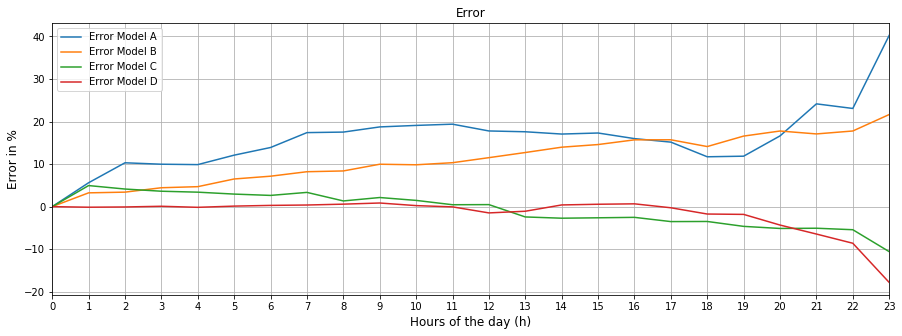

In [35]:
Error_A = ((Revenues_best_day_REAL.values-Revenues_best_day_prediction_A.values)/Revenues_best_day_REAL.values*100)
Error_B = ((Revenues_best_day_REAL.values-Revenues_best_day_prediction_B.values)/Revenues_best_day_REAL.values*100)
Error_C = ((Revenues_best_day_REAL.values-Revenues_best_day_prediction_C.values)/Revenues_best_day_REAL.values*100)
Error_D = ((Revenues_best_day_REAL.values-Revenues_best_day_prediction_D.values)/Revenues_best_day_REAL.values*100)

RMSE_A = np.sqrt(np.sum((Revenues_best_day_REAL.values-Revenues_best_day_prediction_A.values)**2/len(Error_A)))
RMSE_B = np.sqrt(np.sum((Revenues_best_day_REAL.values-Revenues_best_day_prediction_B.values)**2/len(Error_B)))
RMSE_C = np.sqrt(np.sum((Revenues_best_day_REAL.values-Revenues_best_day_prediction_C.values)**2/len(Error_C)))
RMSE_D = np.sqrt(np.sum((Revenues_best_day_REAL.values-Revenues_best_day_prediction_D.values)**2/len(Error_D)))


print('Mean squared error model A =', RMSE_A, 'DKK')
print('Mean squared error model B =', RMSE_B, 'DKK')
print('Mean squared error model C =', RMSE_C, 'DKK')
print('Mean squared error model D =', RMSE_D, 'DKK')

plt.figure(figsize=(15,5))
plt.plot(Error_A, label='Error Model A')
plt.plot(Error_B, label='Error Model B')
plt.plot(Error_C, label='Error Model C')
plt.plot(Error_D, label='Error Model D')
plt.ylabel('Error in %', fontsize=12)
plt.xlabel('Hours of the day (h)', fontsize=12)
plt.xticks(np.arange(24))
plt.xlim((0,23))
plt.grid()
plt.title('Error')
plt.legend()
plt.show()



   ## 7. Conclusion

The four models are able to predict the power production in the selected day, and thus the revenue stream, with a good level of accuracy. The model using 7 days in the past to predict the production shows the best preformances with a mean squared error of 8.60 DKK